In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#import lightgbm as lgb
import xgboost as xgb
from pandas import DataFrame
import math
import matplotlib.pyplot as plt


In [54]:
cutdown_rows = 0
#cutdown_rows = 1000
#cutdown_rows = 10000

key_feature_cutoff = 10

exclude_shared_ownership = True
only_shared_owership = False

LABEL = 'Price'

floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms',
          'nearestStation', 'nearestTram', 'nearestUnderground', 'nearestOverground',
          ]

categories = ['tenure.tenureType',
              'analyticsProperty.soldSTC',
              'analyticsProperty.preOwned',
              #'sharedOwnership.sharedOwnership',
              #
              'analyticsProperty.propertyType',  # 'propertyType',
              #'analyticsProperty.propertySubType',
              'borough',
              ]
custom = [
    'sharedOwnership.sharedOwnership',
    'analyticsProperty.priceQualifier',
    'sharedownership_in_description',
    'keyFeatures'
]
#categories = []

features = floats.copy()
features.extend(categories)
features.extend(custom)
features.insert(0, LABEL)
features

['Price',
 'location.latitude',
 'location.longitude',
 'bedrooms',
 'bathrooms',
 'nearestStation',
 'nearestTram',
 'nearestUnderground',
 'nearestOverground',
 'tenure.tenureType',
 'analyticsProperty.soldSTC',
 'analyticsProperty.preOwned',
 'analyticsProperty.propertyType',
 'borough',
 'sharedOwnership.sharedOwnership',
 'analyticsProperty.priceQualifier',
 'sharedownership_in_description',
 'keyFeatures']

In [55]:
def get_source_dataframe(rows=cutdown_rows):
    df = pd.read_csv('../data/source/df_listings.csv', on_bad_lines='skip', index_col=0)
    df = df[features]

    if rows and rows > 0:
        df = df[:rows]
    return df


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.7, random_state=1)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.7, random_state=1)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        #X_train1 = X_train1[:,3:]
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        #X_test1 = X_test1[:,3:]
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        # X_train_index = pd.to_numeric(X_train_index, 'coerce').astype(int)
        # y_train_index = pd.to_numeric(y_train_index, 'coerce').astype(int)
        # X_test_index = pd.to_numeric(X_test_index, 'coerce').astype(int)
        # y_test_index = pd.to_numeric(y_test_index, 'coerce').astype(int)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index


X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(
    get_source_dataframe(), return_index=True, drop_nulls=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,
X_train[0]

array([51.467869, -0.086037, 1.0, 1.0, 0.1523658055113279, nan, nan,
       0.1523658055113279, False, 'Offers Over', False,
       "['Bright One Bedroom Top Floor Flat', 'Scope For Further Upgrade To Taste','Light And Spacious Reception Room', 'Separate Well Equipped Kitchen','Bathroom With White Suite', 'Gas Central Heating', 'Close To Denmark HillStation And Bus Routes', 'Easy Access Shops And Amenities', 'No Onward Chain','Convenient Denmark Hill Location & Camberwell Grove Conservation Area']",
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0], dtype=object)

In [56]:
df = get_source_dataframe()
df_orig = df.copy()
print(df.shape)
df[:5]

(26633, 18)


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground,tenure.tenureType,analyticsProperty.soldSTC,analyticsProperty.preOwned,analyticsProperty.propertyType,borough,sharedOwnership.sharedOwnership,analyticsProperty.priceQualifier,sharedownership_in_description,keyFeatures
14520525,550000,51.529950,-0.207020,3.0,1.0,0.274316,NaN,0.274316,0.274316,LEASEHOLD,False,Resale,Flats / Apartments,Westminster,False,None,False,"['Maisonette', 'Private Balcony', 'Spacious / ..."
27953107,400000,51.549390,-0.482600,2.0,2.0,0.305845,NaN,0.305845,NaN,LEASEHOLD,False,Resale,Flats / Apartments,Hillingdon,False,Offers in Excess of,False,"['TWO DOUBLE BEDROOMS', 'LOUNGE AREA', 'MODERN..."
33593487,579950,51.447180,-0.338770,2.0,1.0,0.438045,NaN,NaN,0.438045,FREEHOLD,False,Resale,Houses,Richmond upon Thames,False,Offers in Excess of,False,"['Mid Terrace Victorian Home', '2 Double Bedro..."
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,NaN,0.399307,0.704048,LEASEHOLD,False,Resale,Flats / Apartments,Lambeth,False,Offers in Region of,False,"['2 bedroom second floor flat', 'Great locatio..."
35429088,599950,51.577030,-0.141230,2.0,1.0,0.238187,NaN,0.238187,1.054653,NaN,False,Resale,Flats / Apartments,Haringey,False,None,False,[]


In [57]:
if 'nearestTram' in features:
    df['nearestTram'] = df['nearestTram'].fillna(99)
    df['nearestOverground'] = df['nearestOverground'].fillna(99)
    df['nearestUnderground'] = df['nearestUnderground'].fillna(99)
    df['nearestStation'] = df['nearestStation'].fillna(99)

    imputer = SimpleImputer(strategy='constant', fill_value=99)
    imputer.fit(df['nearestTram'].values.reshape(-1, 1))
    df['nearestTram'] = imputer.transform(df['nearestTram'].values.reshape(-1, 1))
    df['nearestUnderground'] = imputer.transform(df['nearestUnderground'].values.reshape(-1, 1))
    df['nearestOverground'] = imputer.transform(df['nearestOverground'].values.reshape(-1, 1))
    df['nearestStation'] = imputer.transform(df['nearestStation'].values.reshape(-1, 1))

from string import punctuation

if 'keyFeatures' in features:
    df['keyFeatures'] = df['keyFeatures'].str.lower()
    out = []

    punctuation += '('
    for row in df['keyFeatures']:
        row3 = row.strip("][").split("\', \'")
        row3 = [s.strip(punctuation).lower().strip() for s in row3]
        out.extend(row3)

    counts = pd.Series(out).value_counts()
    counts.reset_index()

    c3 = pd.DataFrame(counts, columns=['a'])
    c3.reset_index(inplace=True)
    c3 = c3[c3['a'] > key_feature_cutoff]

    key_features = list(c3['index'])

    for each_key_feature in key_features:


        if each_key_feature != '':
            try:
                feature_name = "key__" + each_key_feature
                #print(f"{feature_name}: {each_key_feature}")

                df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
                df[feature_name] = pd.to_numeric(df[feature_name], 'coerce').dropna().astype(int)
            except:
                print('couldnt process:', each_key_feature)



if 'analyticsProperty.priceQualifier' in features:

    if 'keyFeatures' in features:

        # df[df['keyFeatures'].str.contains('shared ownership')]
        df['sharedOwnership'] = (
                (df['sharedOwnership.sharedOwnership'] == True) |
                (df['analyticsProperty.priceQualifier'] == 'Shared ownership') |
                (df['keyFeatures'].str.contains('shared ownership')) |
                ((df['keyFeatures'].str.contains('share')) & (df['keyFeatures'].str.contains('%'))) |
                (df['sharedownership_in_description'])
        )

        df.drop(['keyFeatures'], axis=1, inplace=True)
    else:
        df['sharedOwnership'] = (
                (df['sharedOwnership.sharedOwnership'] == True) |
                (df['analyticsProperty.priceQualifier'] == 'Shared ownership')
        )

    df['sharedOwnership'] = pd.to_numeric(df['sharedOwnership'], 'coerce').dropna().astype(int)
    df.drop(['sharedOwnership.sharedOwnership'], axis=1, inplace=True)

    if 'analyticsProperty.priceQualifier' not in categories:
        df.drop(['analyticsProperty.priceQualifier'], axis=1, inplace=True)

    if 'sharedownership_in_description' not in categories:
        df.drop(['sharedownership_in_description'], axis=1, inplace=True)

    #df.drop(['shared_ownership'], axis=1, inplace=True)
if exclude_shared_ownership:
    df = df[df['sharedOwnership'] == 0]

if only_shared_owership:
    df = df[df['sharedOwnership'] == 1]


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: potential to extend (stpp


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: sale by modern auction (t&cs apply


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: two bathrooms (one en-suite


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: scope to extend (stpp


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: potential toextend (stpp


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: potential to extend(stpp


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

couldnt process: **ready to move into**


/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df['keyFeatures'].str.contains(each_key_feature)
/tmp/ipykernel_3116/4093918405.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

In [58]:
#df[df['keyFeatures'].str.contains('shared ownership')]
#df['keyFeatures'] = df['keyFeatures'].apply(lambda x: x.astype(str).str.upper())
#df

In [59]:

df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground,tenure.tenureType,...,key__garage & off street parking,key__chainfree sale,key__beautiful condition,key__moments from amenities,key__no-onward chain,key__open plan layout,key__open plan kitchen/living,key__set on the ground floor,key__two bedroom ground floor maisonette,sharedOwnership
14520525,550000,51.529950,-0.207020,3.0,1.0,0.274316,99.000000,0.274316,0.274316,LEASEHOLD,...,0,0,0,0,0,0,0,0,0,0
27953107,400000,51.549390,-0.482600,2.0,2.0,0.305845,99.000000,0.305845,99.000000,LEASEHOLD,...,0,0,0,0,0,0,0,0,0,0
33593487,579950,51.447180,-0.338770,2.0,1.0,0.438045,99.000000,99.000000,0.438045,FREEHOLD,...,0,0,0,0,0,0,0,0,0,0
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,99.000000,0.399307,0.704048,LEASEHOLD,...,0,0,0,0,0,0,0,0,0,0
35429088,599950,51.577030,-0.141230,2.0,1.0,0.238187,99.000000,0.238187,1.054653,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121677479,450000,51.483748,-0.388508,3.0,2.0,0.709062,99.000000,0.709062,99.000000,FREEHOLD,...,0,0,0,0,0,0,0,0,0,0
121677749,300000,51.532990,0.036340,2.0,1.0,0.178077,99.000000,0.178077,99.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
121678004,475000,51.393990,0.045193,2.0,2.0,0.444410,99.000000,99.000000,0.444410,LEASEHOLD,...,0,0,0,0,0,0,0,0,0,0
121678103,200000,51.410742,-0.225795,NaN,1.0,0.205738,0.917064,99.000000,0.205738,LEASEHOLD,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25422 entries, 14520525 to 121678256
Columns: 1245 entries, Price to sharedOwnership
dtypes: bool(1), float64(8), int64(1232), object(4)
memory usage: 241.5+ MB


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground,key__chain free,...,key__garage & off street parking,key__chainfree sale,key__beautiful condition,key__moments from amenities,key__no-onward chain,key__open plan layout,key__open plan kitchen/living,key__set on the ground floor,key__two bedroom ground floor maisonette,sharedOwnership
count,25422.000000,25417.000000,25422.000000,24503.000000,23857.000000,25422.000000,25422.000000,25422.000000,25422.000000,25422.000000,...,25422.000000,25422.000000,25422.000000,25422.000000,25422.000000,25422.000000,25422.000000,25422.000000,25422.000000,25422.0
mean,414109.045118,51.498362,-0.107655,1.985879,1.176259,0.449262,92.868166,46.986987,11.836216,0.146487,...,0.000669,0.000433,0.000944,0.000708,0.000472,0.000708,0.002950,0.000669,0.000590,0.0
std,110776.268300,0.075232,0.740602,0.833672,0.404319,1.285944,23.788286,49.140186,31.450173,0.353601,...,0.025851,0.020797,0.030712,0.026600,0.021722,0.026600,0.054237,0.025851,0.024284,0.0
min,100000.000000,51.298320,-0.497861,1.000000,1.000000,0.000000,0.005282,0.006731,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,325000.000000,51.443670,-0.216580,1.000000,1.000000,0.223922,99.000000,0.423452,0.276878,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,420000.000000,51.501270,-0.104980,2.000000,1.000000,0.363214,99.000000,1.475054,0.464421,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,500000.000000,51.554526,-0.011520,2.000000,1.000000,0.558825,99.000000,99.000000,0.792294,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,600000.000000,51.683060,51.558746,7.000000,5.000000,192.431869,99.000000,99.000000,192.431869,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [61]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)
#X_train[:5]


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#X_train_index
print(type(X_train))
X_train[0]

(15172, 1284) (6503, 1284) (15172, 1) (6503, 1) (15172, 1) (6503, 1) (15172, 1) (6503, 1)
<class 'numpy.ndarray'>


array([51.396886, -0.128418,  3.      , ...,  0.      ,  0.      ,
        0.      ])

In [62]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [63]:
print(tf.__version__)


def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        #layers.Dense(132, activation='relu'),
        #layers.Dense(132, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


X_train2 = np.asarray(X_train).astype('float32')
y_train2 = np.asarray(y_train).astype('float32')

normalizer = tf.keras.layers.Normalization(axis=-1)

dnn_model = build_and_compile_model(normalizer)

# % % time
history = dnn_model.fit(
    X_train,  # train_features,
    y_train2,  # train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

print(dnn_model.evaluate(X_test, y_test, verbose=0))

model = dnn_model

2.10.0


2022-10-08 18:18:29.917893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62335632 exceeds 10% of free system memory.


51859.25390625


In [64]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 1284) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
normalization_2 (None, 1284) float32
dense_6 (None, 1284) float32
dense_7 (None, 64) float32
dense_8 (None, 64) float32


[None, None, None, None]

In [65]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 1284) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
normalization_2 (None, 1284) float32
dense_6 (None, 1284) float32
dense_7 (None, 64) float32
dense_8 (None, 64) float32


[None, None, None, None]

In [66]:
if False:
    pipe = Pipeline(steps=[
        ('preprocessor', features_preprocessor),  # preprocess features
        ('estimator', dnn_model),
    ])  # start the training

    params = {}
    grid = GridSearchCV(pipe, param_grid=params, cv=3, n_jobs=1, verbose=1, scoring='neg_mean_absolute_error')
    #grid.fit(X_train, y_train)
    #pipe.fit(X_train, y_train)
    history = pipe.fit(
        X_train,  # train_features,
        y_train,  # train_labels,
        validation_split=0.2,
        verbose=0, epochs=100)

    print("\nBest Score\n", grid.best_score_)
    best_estimator_pipe = grid.best_estimator_


In [67]:
result = model.predict(X_test)

204/204 [==============================] - 1s 3ms/step


In [68]:
print(result)

[[369802.66]
 [427586.7 ]
 [544756.44]
 ...
 [309302.66]
 [327703.25]
 [349696.6 ]]


In [69]:
print(y_test_index.reshape((-1, 1)).shape)
print(result.reshape((-1, 1)).shape)
print(y_test.shape)

print(y_test_index.shape)
print(result.shape)
print(y_test.shape)

(6503, 1)
(6503, 1)
(6503, 1)
(6503, 1)
(6503, 1)
(6503, 1)


In [70]:
compare = np.hstack((y_test_index, y_test, result))
#compare[0:4]

In [71]:
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
117821453,325000.0,369802.65625,44802.65625,13.785433,12.115288
118600661,350000.0,427586.68750,77586.68750,22.167625,18.145253
110855147,600000.0,544756.43750,55243.56250,9.207260,10.140966
115786904,220000.0,245637.65625,25637.65625,11.653480,10.437185
120028451,500000.0,454789.12500,45210.87500,9.042175,9.941063
...,...,...,...,...,...
118902122,500000.0,500897.90625,897.90625,0.179581,0.179259
115328102,595000.0,582389.18750,12610.81250,2.119464,2.165358
110494268,270000.0,309302.65625,39302.65625,14.556539,12.706860


In [72]:
compare_df.join(df_orig).sort_values(by='diff 1 %', ascending=False)
# 85514838
# 115470422

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,...,nearestOverground,tenure.tenureType,analyticsProperty.soldSTC,analyticsProperty.preOwned,analyticsProperty.propertyType,borough,sharedOwnership.sharedOwnership,analyticsProperty.priceQualifier,sharedownership_in_description,keyFeatures
reference,,,,,,,,,,,,,,,,,,,,,
96587059,114000.0,481672.781250,367672.781250,322.519984,76.332480,114000,51.523430,-0.151770,1.0,1.0,...,NaN,LEASEHOLD,False,New Home,Flats / Apartments,Westminster,False,None,False,"['Located in London', '6.5% Net Rental Income'..."
109722224,108000.0,331531.281250,223531.281250,206.973409,67.423888,108000,51.406803,-0.261328,1.0,1.0,...,0.302667,LEASEHOLD,False,Resale,Flats / Apartments,Kingston upon Thames,False,None,False,[]
115558067,124000.0,304776.187500,180776.187500,145.787248,59.314407,124000,51.377604,-0.158750,2.0,1.0,...,0.209794,LEASEHOLD,True,Resale,Flats / Apartments,Sutton,False,None,False,[]
114428018,150000.0,346447.656250,196447.656250,130.965104,56.703416,150000,51.440630,-0.096990,1.0,1.0,...,0.274950,LEASEHOLD,False,Resale,Flats / Apartments,Lambeth,False,None,False,"['One double bedroom', 'Private balcony ', 'Ch..."
116734478,210000.0,457741.781250,247741.781250,117.972277,54.122606,210000,51.595061,-0.082197,3.0,1.0,...,0.508535,LEASEHOLD,False,Resale,Flats / Apartments,Haringey,False,Offers in Excess of,False,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120179363,450000.0,449931.125000,68.875000,0.015306,0.015308,450000,51.550251,-0.130388,1.0,1.0,...,0.452870,LEASEHOLD,True,Resale,Flats / Apartments,Camden,False,None,False,['CHAIN FREE! A spacious (approximately 537 Sq...
85502388,450000.0,449962.343750,37.656250,0.008368,0.008369,450000,51.563388,0.142143,3.0,1.0,...,0.638616,FREEHOLD,True,Resale,Houses,Barking and Dagenham,False,None,False,"['EPC RATING - TBC', 'THREE BEDROOMS', 'OPEN P..."
116491589,450000.0,449970.531250,29.468750,0.006549,0.006549,450000,51.573380,0.214500,3.0,1.0,...,0.410770,FREEHOLD,True,Resale,Houses,Havering,False,Guide Price,False,[]


In [73]:
compare_df.join(df)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,...,key__garage & off street parking,key__chainfree sale,key__beautiful condition,key__moments from amenities,key__no-onward chain,key__open plan layout,key__open plan kitchen/living,key__set on the ground floor,key__two bedroom ground floor maisonette,sharedOwnership
reference,,,,,,,,,,,,,,,,,,,,,
117821453,325000.0,369802.65625,44802.65625,13.785433,12.115288,325000,51.535220,-0.345520,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
118600661,350000.0,427586.68750,77586.68750,22.167625,18.145253,350000,51.523632,-0.031687,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
110855147,600000.0,544756.43750,55243.56250,9.207260,10.140966,600000,51.452580,0.032040,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
115786904,220000.0,245637.65625,25637.65625,11.653480,10.437185,220000,51.574209,0.185169,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
120028451,500000.0,454789.12500,45210.87500,9.042175,9.941063,500000,51.665047,-0.085912,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118902122,500000.0,500897.90625,897.90625,0.179581,0.179259,500000,51.589430,0.211538,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
115328102,595000.0,582389.18750,12610.81250,2.119464,2.165358,595000,51.611673,-0.329256,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
110494268,270000.0,309302.65625,39302.65625,14.556539,12.706860,270000,51.575031,0.112690,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
if False:
    model.score(X_test, y_test)

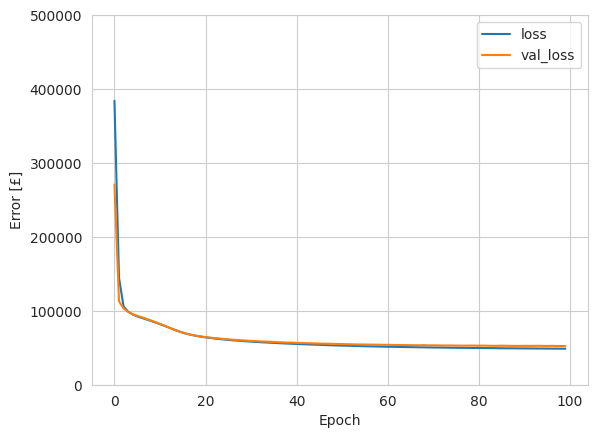

In [75]:
def plot_loss(history):

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 500000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [£]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [76]:
print(", ".join([str(x) for x in history.history["loss"][:5]]))
print('...')
print(", ".join([str(x) for x in history.history["loss"][-5:]]))

384183.6875, 144619.046875, 105975.0234375, 98921.09375, 95083.6796875
...
48882.5390625, 48852.9765625, 48854.72265625, 48763.0546875, 48740.171875


In [77]:

#test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
dnn_model.evaluate(X_test, y_test, verbose=0)


51859.25390625